In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable


class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  real myBetaPrior_lpdf(real x, real beta) {
      return -log(beta); // log(1/beta) = log(1) - log(beta) = - log(beta)
  }
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  real alpha;
  real beta;
}
model {
  // Priors; no priors - we assume improper priors on params
  alpha ~ gamma(1,1);
  beta ~ gamma(1,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }
}
generated quantities{}
"""

In [3]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(1,1);
  alpha2 ~ gamma(1,1);
  beta ~ gamma(1,1);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [4]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta)

def quantiles_GPD(excesses, k, u): 
    """ 
    we forward to function array of the quantiles as excesses, the number of excesses, k, and the border value u
    """
    quant_GPD = np.zeros(len(q)) 
    bayesian_quant_GPD = np.zeros(len(q))

    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate GPD quantiles and their traceplots to calculate Bayesian GPD quantiles
    traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
    traceplot_alpha = list(fit.extract().values())[0].tolist()
    traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
    alpha = np.mean(list(fit.extract().values())[0].tolist())
    gamma = 1 / alpha 
    
    for i in range(len(q)):
        quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
        for j in range(len(traceplot_gamma)):
                bayesian_quant_GPD[i] += u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
    bayesian_quant_GPD = bayesian_quant_GPD / len(traceplot_gamma)
    list_of_params = [alpha, beta_GPD]
    return(quant_GPD, bayesian_quant_GPD, list_of_params ) # it return arrays: quant_GPD, bayesian_quant_GPD and values alpha, beta_GPD

def quantiles_Fisher(excesses, k, u):
    quant_Fisher = np.zeros(len(q)) 
    bayesian_quant_Fisher = np.zeros(len(q))
    
    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_beta = list(fit.extract().values())[2].tolist()
    traceplot_alpha1 = list(fit.extract().values())[1].tolist()
    traceplot_alpha2 = list(fit.extract().values())[0].tolist()
    beta = np.mean(list(fit.extract().values())[2].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    beta0 = alpha2/alpha1
    
    for i in range(len(q)):
        quant_Fisher[i] = u + beta0 / beta * f.isf(N / k * (1-q[i]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)
        for j in range(len(traceplot_alpha1)):
                bayesian_quant_Fisher[i] += u + traceplot_alpha2[j] / traceplot_alpha1[j] / traceplot_beta[j] * f.isf(N / k *(1- q[i]), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale=1)
    bayesian_quant_Fisher = bayesian_quant_Fisher / len(traceplot_alpha1)
    list_of_params = [alpha1, alpha2, beta]
    return(quant_Fisher, bayesian_quant_Fisher, list_of_params) 
# it return arrays: quant_Fisher, bayesian_quant_Fisher and values of params as a list


In [5]:
def plot_table(k, averaged_bayesian_quant_Fisher, averaged_quant_Fisher, averaged_bayesian_quant_GPD, averaged_quant_GPD):
    m = "3" # how much we round
    rounding = "%." + m + "f"
    m = int(m)
    t_quantiles = PrettyTable(["# of excesses k = " +  str(k),  
                               'mean', 
                               'sd',
                               str(q[0] * 100) + "%", 
                               str(q[1] * 100) + "%",
                               str(q[2] * 100) + "%",
                               str(q[3] * 100) + "%",
                               str(q[4] * 100) + "%"])
    t_quantiles.add_row(['theoretically', '--', '--',
                         rounding % round(quant_th[0],m),  
                         rounding % round(quant_th[1], m), 
                         rounding % round(quant_th[2], m),
                         rounding % round(quant_th[3], m),
                         rounding % round(quant_th[4], m) ])
    t_quantiles.add_row(['Bayes Fisher',  '--', '--',
                         rounding % round(averaged_bayesian_quant_Fisher[0],m),  
                         rounding % round(averaged_bayesian_quant_Fisher[1], m), 
                         rounding % round(averaged_bayesian_quant_Fisher[2], m),
                         rounding % round(averaged_bayesian_quant_Fisher[3], m),
                         rounding % round(averaged_bayesian_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Fisher',  '--', '--',
                         rounding % round(averaged_quant_Fisher[0],m),  
                         rounding % round(averaged_quant_Fisher[1], m), 
                         rounding % round(averaged_quant_Fisher[2], m),
                         rounding % round(averaged_quant_Fisher[3], m),
                         rounding % round(averaged_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Bayes GPD', '--', '--',
                         rounding % round(averaged_bayesian_quant_GPD[0],m),  
                         rounding % round(averaged_bayesian_quant_GPD[1], m), 
                         rounding % round(averaged_bayesian_quant_GPD[2], m),
                         rounding % round(averaged_bayesian_quant_GPD[3], m),
                         rounding % round(averaged_bayesian_quant_GPD[4], m) ])
    t_quantiles.add_row(['GPD',  '--', '--',
                         rounding % round(averaged_quant_GPD[0],m),  
                         rounding % round(averaged_quant_GPD[1], m), 
                         rounding % round(averaged_quant_GPD[2], m),
                         rounding % round(averaged_quant_GPD[3], m),
                         rounding % round(averaged_quant_GPD[4], m) ])
    return(print(t_quantiles))

In [6]:
def plot_variability(jump_excesses, method, quantile_level, title):
    plt.plot(jump_excesses, method )
    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(quantile_level))
    plt.title('Variability of quantile at level ' + str(quantile_level) + ' obtained with: ' + title )
    return(plt.show())

In [7]:
def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [22]:
n = 3 # number of sampled dataset over which we average the quantiles
N, beta = 1000,  1/2

r = frechet.rvs(beta, size=N)
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [24]:
how_many_different_thresholds = 3
min_thresholds = 50
max_thresholds = N / 2
# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

averaged_params_GPD, averaged_params_Fisher =  np.zeros(number_of_GPD_params), np.zeros(number_of_Fisher_params)

averaged_quant_GPD, averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
averaged_quant_Fisher, averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

# we initialize the matrices of quantiles with row of zeros
concatenated_averaged_quant_GPD, concatenated_averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_quant_Fisher, concatenated_averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

counter = 0 # counter to normalize over the values of parameters

for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    
    # in data frechet we keep the matrix of excesses
    # transferred r is a matrix with n sampled dataset from Frechet
    
    data_frechet, u = k_greatest_values_matrices(r,k) 

    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)

    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 

    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    counter = counter +  1
    
    for i in range(n): 
        
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] # asarray(C.transpose().tolist()[i]) 
        quant_GPD, bayesian_quant_GPD, params_GPD = quantiles_GPD(excesses_array, k, u[i])
        quant_Fisher, bayesian_quant_Fisher, params_Fisher = quantiles_Fisher(excesses_array, k, u[i])
        print("\n quant_Fisher : \n ", quant_Fisher,"\n bayesian_quant_Fisher: \n", bayesian_quant_Fisher)
    averaged_quant_GPD += quant_GPD
    averaged_bayesian_quant_GPD += bayesian_quant_GPD
    averaged_params_GPD += params_GPD 
        print("\n averaged_quant_GPD \n ", averaged_quant_GPD, "\n averaged_bayesian_quant_GPD \n", averaged_bayesian_quant_GPD)
        
    averaged_quant_Fisher += quant_Fisher
    print("\n averaged_quant_Fisher: \n", averaged_quant_Fisher)
    averaged_bayesian_quant_Fisher += bayesian_quant_Fisher
    print("\n averaged_bayesian_quant_Fisher: \n", averaged_bayesian_quant_Fisher)
    averaged_params_Fisher += params_Fisher 

        
    print("\n counter: \n", counter)    
    averaged_quant_GPD = averaged_quant_GPD / counter 
    averaged_bayesian_quant_GPD = averaged_bayesian_quant_GPD / counter
    averaged_params_GPD = asarray(averaged_params_GPD) / counter

    averaged_quant_Fisher = averaged_quant_Fisher / counter 
    averaged_bayesian_quant_Fisher = averaged_bayesian_quant_Fisher / counter
    averaged_params_Fisher = asarray(averaged_params_Fisher) / counter
    
    print("quant_Fisher \n ",averaged_quant_Fisher, "bayesian_quant_Fisher \n ", averaged_bayesian_quant_Fisher )
    
    plot_table(jump_excesses[j], 
           averaged_bayesian_quant_Fisher, 
           averaged_quant_Fisher, 
           averaged_bayesian_quant_GPD, 
           averaged_quant_GPD)
    
    print(" Current number of excesses k = " + str(jump_excesses[j]), 
          "\n", "averaged_params_GPD: ", averaged_params_GPD, 
          "\n", "averaged_params_Fisher: ", averaged_params_Fisher)
    
    #preparing to plot
    
    concatenated_averaged_quant_GPD = np.column_stack( (concatenated_averaged_quant_GPD, averaged_quant_GPD ) )
    concatenated_averaged_bayesian_quant_GPD = np.column_stack( (concatenated_averaged_bayesian_quant_GPD, averaged_bayesian_quant_GPD ) )
    concatenated_averaged_quant_Fisher = np.column_stack( (concatenated_averaged_quant_Fisher, averaged_quant_Fisher ) )
    concatenated_averaged_bayesian_quant_Fisher = np.column_stack( (concatenated_averaged_bayesian_quant_Fisher, averaged_bayesian_quant_Fisher ) )

# we delete first column which was created as zeros
concatenated_averaged_quant_GPD = np.delete(concatenated_averaged_quant_GPD, 0, 1)
concatenated_averaged_bayesian_quant_GPD = np.delete(concatenated_averaged_bayesian_quant_GPD, 0, 1)
concatenated_averaged_quant_Fisher = np.delete(concatenated_averaged_quant_Fisher, 0, 1)
concatenated_averaged_bayesian_quant_Fisher = np.delete(concatenated_averaged_bayesian_quant_Fisher, 0, 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.53632968  6.65613117  8.71777731 22.91608746 38.77082968] 
 bayesian_quant_Fisher: 
 [nan nan nan nan nan]

 averaged_quant_GPD 
  [  7.27520071  11.03934251  17.85611558  63.07565526 112.09266506] 
 averaged_bayesian_quant_GPD 
 [  7.30580556  11.37906786  19.48403136  91.57521714 198.57112265]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.37736524  7.12087252 10.47226662 35.34030592 64.71554312] 
 bayesian_quant_Fisher: 
 [nan nan nan nan nan]

 averaged_quant_GPD 
  [ 13.26320543  19.73189703  31.72654608 115.07706801 208.87815102] 
 averaged_bayesian_quant_GPD 
 [ 13.3106329   20.35882045  34.93261365 182.03005205 438.57016917]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.81746758  5.34075707  6.0743885   9.20392    11.58343349] 
 bayesian_quant_Fisher: 
 [ 5.16908707  6.03061958  7.21413341 12.17441468 15.96635572]

 averaged_quant_GPD 
  [ 20.18847597  29.9021649   46.78390789 153.22774215 266.07510789] 
 averaged_bayesian_quant_GPD 
 [ 20.28062329  30.77692743  50.83393669 227.93752162 513.74391683]

 averaged_quant_Fisher: 
 [ 4.81746758  5.34075707  6.0743885   9.20392    11.58343349]

 averaged_bayesian_quant_Fisher: 
 [ 5.16908707  6.03061958  7.21413341 12.17441468 15.96635572]

 counter: 
 1
quant_Fisher 
  [ 4.81746758  5.34075707  6.0743885   9.20392    11.58343349] bayesian_quant_Fisher 
  [ 5.16908707  6.03061958  7.21413341 12.17441468 15.96635572]
+----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 50 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+----------------------+------+----+--------+--------+--------+---------+---------+
|    theoretically  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.46840513 11.04526745 16.37082539 41.03016192 61.02630949] 
 bayesian_quant_Fisher: 
 [  6.5769849   11.11425424  19.63071834  81.07426484 153.01539309]

 averaged_quant_GPD 
  [ 28.13866561  41.56644066  63.83228984 194.027513   325.35961338] 
 averaged_bayesian_quant_GPD 
 [ 28.33798763  42.74423851  68.60823524 272.77674942 580.86246538]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.56027998 10.86389074 15.55253377 35.46610282 50.46979427] 
 bayesian_quant_Fisher: 
 [  5.79562609  10.03862806  18.56885226  88.49779242 178.42858986]

 averaged_quant_GPD 
  [ 34.89278397  51.0819811   77.20956909 223.37960945 366.47752623] 
 averaged_bayesian_quant_GPD 
 [ 35.18310353  52.5008772   82.53190038 304.83055444 626.96746607]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.67179619 10.99779558 15.73210692 35.95026861 51.25633474] 
 bayesian_quant_Fisher: 
 [  6.293844    10.67017786  19.14265816  84.00434266 163.45738569]

 averaged_quant_GPD 
  [ 41.813361    60.90343663  91.1507125  254.83732695 411.14544653] 
 averaged_bayesian_quant_GPD 
 [ 42.20628061  62.60612978  97.1390904  339.83027589 678.37571425]

 averaged_quant_Fisher: 
 [12.48926377 16.33855265 21.80649542 45.15418862 62.83976823]

 averaged_bayesian_quant_Fisher: 
 [ 11.46293106  16.70079744  26.35679157  96.17875733 179.42374141]

 counter: 
 2
quant_Fisher 
  [ 6.24463189  8.16927633 10.90324771 22.57709431 31.41988411] bayesian_quant_Fisher 
  [ 5.73146553  8.35039872 13.17839579 48.08937867 89.71187071]
+-----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 275 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+---------+---------+
|     t

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [11.20436636 16.51223734 24.10207192 56.77514189 81.67910128] 
 bayesian_quant_Fisher: 
 [  9.87040534  18.33411945  34.82582168 161.6390533  316.62539743]

 averaged_quant_GPD 
  [ 28.80124946  41.91236379  62.13195323 165.88511714 260.72083327] 
 averaged_bayesian_quant_GPD 
 [ 29.1240371   43.06510427  65.7752019  211.46934969 400.03210711]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.0826016  14.23464737 19.89271816 42.25700322 58.09296357] 
 bayesian_quant_Fisher: 
 [  7.74559421  13.21315226  23.07694862  88.5523706  159.98187685]

 averaged_quant_GPD 
  [ 35.57606602  51.18624235  74.72892901 191.05363788 294.45351578] 
 averaged_bayesian_quant_GPD 
 [ 35.96882134  52.49494207  78.68481681 237.88778437 435.89923338]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.



 quant_Fisher : 
  [10.3634656  14.74064322 20.74796787 44.78645806 61.9897194 ] 
 bayesian_quant_Fisher: 
 [  8.2800654   14.88447747  27.52442119 121.35575832 232.92008513]

 averaged_quant_GPD 
  [ 42.49879377  60.75723981  87.87955522 218.1438056  331.28455692] 
 averaged_bayesian_quant_GPD 
 [ 42.98287834  62.26993405  92.24795799 266.68067163 475.68710814]

 averaged_quant_Fisher: 
 [16.60809748 22.90991954 31.65121557 67.36355236 93.40960351]

 averaged_bayesian_quant_Fisher: 
 [ 14.01153094  23.23487619  40.70281697 169.44513699 322.63195583]

 counter: 
 3
quant_Fisher 
  [ 5.53603249  7.63663985 10.55040519 22.45451745 31.1365345 ] bayesian_quant_Fisher 
  [  4.67051031   7.74495873  13.56760566  56.48171233 107.54398528]
+-----------------------+------+----+--------+--------+--------+--------+---------+
| # of excesses k = 500 | mean | sd | 98.0%  | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+--------+---------+
|    

In [10]:
def compare_quantiles(jump_excesses, GPD, BGPD, Fisher, theoretical_quantile,  quantile_level):
    plt.hlines(y=theoretical_quantile[quantile_level], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='yellow', 
               zorder=1, 
               label='theoretical value')
    plt.plot(jump_excesses, GPD[quantile_level,:],  'r', label='GPD') # plotting t, a separately 
    plt.plot(jump_excesses, BGPD[quantile_level,:], 'b', label='BGPD') # plotting t, b separately 
    plt.plot(jump_excesses, Fisher[quantile_level,:], 'g', label='Fisher') # plotting t, c separately 
    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[quantile_level]))
    plt.title('Variability of quantile at level ' + str(q[quantile_level])  )
    plt.legend()
    return(plt.show())

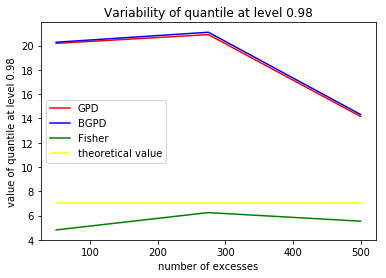

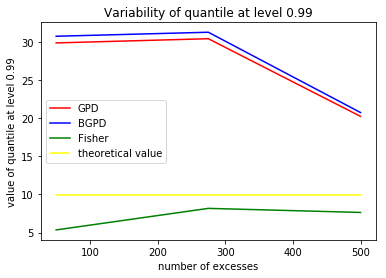

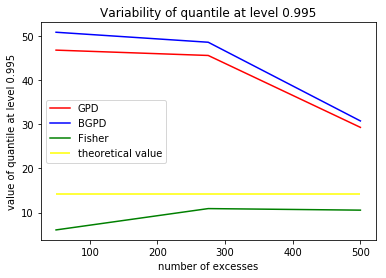

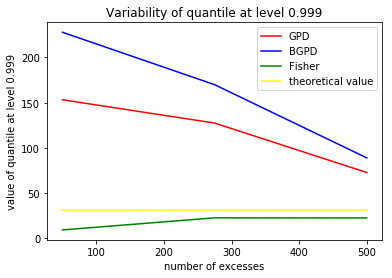

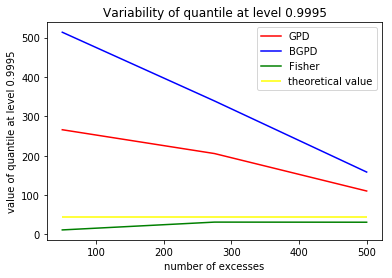

In [25]:
for i in range(len(q)):
    compare_quantiles(jump_excesses,
                  concatenated_averaged_quant_GPD, 
                  concatenated_averaged_bayesian_quant_GPD, 
                  concatenated_averaged_quant_Fisher, 
                  quant_th,
                  i)

In [17]:
counter = 0 # counter to normalize over the values of parameters
n = 1
for i in range(1,n): 
    counter = counter +  1
print(counter)

0


In [12]:
# concatenated_averaged_quant_Fisher[3, :] 
# str(concatenated_averaged_quant_Fisher[3, :])
# 3 stands for the same level of quantile but for different number of excesses 
# instead of 3 we should be able to use i in 0, 1, 2, 3, 4, those represents different levels of quantiles 